# Comportement vibratoire d'une poutre métallique

In [45]:
%matplotlib inline

import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colormaps
from matplotlib.colors import Normalize
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 14,
})

## Description et données du problème

On se propose d'étudier le comportement vibratoire d'une poutre métallique sous chargement harmonique extérieur :

![Poutre métallique](pictures/TD6-PoutreRectangulaire.png)

La poutre de section rectangulaire est composé d'un métal présentant un module de conservation $E = 210\,\mathrm{GPa}$, un facteur de perte $\eta = 0.01$, et d'une densité $\rho = 7830\,\mathrm{kg\,mm}^{-3}$.

Les autres données du problème sont :

| $L$     | $h$     | $b$     | $\rho$  | $E$     | $\eta$  | $\omega_{\mathrm{ext}}$ | $F_{\mathrm{ext}}$ | 
|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|:-----------------------:|:----------------------:|
| $1000\,\mathrm{mm}$ | $10\,\mathrm{mm}$ | $20\,\mathrm{mm}$ | $7830\,\mathrm{kg\,m}^{-3}$ | $210\,\mathrm{GPa}$ | $0.01$ | $0.1\,\mathrm{rad\,ms^{-1}}$ | $10\,\mathrm{N}$ |

Ces données sont exprimées dans des unités possiblement arbitraires. Pour utiliser ces valeurs, il faut faire un travail préliminaire pour se ramener à un [système consistant d'unité](https://www.dynasupport.com/howtos/general/consistent-units) (plus de détails dans la correction du TD5). Ici sur une structure métallique où certaines dimensions sont de quelques millimètres, il est plus pertinent de travailler dans le système $(\mathrm{g, mm, ms, N, MPa})$.

In [46]:
rho = 7.83e-03 # Density [g/mm3]
E = 210E3 # Young's modulus [MPa]
eta = 0.01 # Facteur de perte [-]
Estar = E * (1.0 + 1.0j*eta) # Module complexe
L = 1000 # Length [mm]
h = 10 # Thickness [mm]
b = 20 # Width [mm]
A = b*h # Area of the cross-section [mm2]
I = b*h**3/12.0 # Second moment of area [mm4]

wext =  0.1 # Pulsation excitation [rad/ms]
Fext = 10.0 # Amplitude mvt du support [mm]

## Modes de vibrations

Intéressons nous dans un premier temps aux modes de vibrations de notre poutre. Ces modes de vibrations permettent d'avoir une idée assez précise de ce qu'il va se passer lorsque la poutre va être sollicitée dynamiquement. En particulier, il y a un **lien étroit entre les modes de vibrations et les phénomènes de résonance de la structure** : les phénomènes de résonance ont lieu lorsque la pulsation d'excitation se rapproche des pulsations propres.

Pour obtenir les modes de vibrations, écrivons les équations du mouvement de la poutre :
$$
\boxed{
    \rho{}A\ddot{u}_y(t,x) + EI u_y^{\prime\prime\prime\prime}(t,x) = 0, \quad\forall{t}, \forall{x},
}
$$
à laquelle viennent s'ajouter les conditions aux limites :

* Déplacement vertical bloqué en $x = 0$ : $$\boxed{u_y(t, x=0) = 0,~~\forall{t}.}$$
* Rotation bloquée en $x = 0$ : $$\boxed{u_y^{\prime}(t, x=0) = 0,~~\forall{t}.}$$
* Rotation bloquée en $x = L$ : $$\boxed{u_y^{\prime}(t, x=L) = 0,~~\forall{t}.}$$
* Déplacement vertical  libre en $x = L$, c'est-à-dire effort tranchant nul en $x = L$ : $$\boxed{u_y^{\prime\prime\prime}(t, x=L) = 0,~~\forall{t}.}$$

Les modes de vibrations sont obtenus en recherchant des solutions bien particulières, de la forme :
$$
    u_y(t,x)
    =
    U(x)\cos(\omega{}t - \varphi).
$$
Plus précisément, il s'agit de trouver les doublets *pulsation + forme propres* $(\omega_j, U_j(x))$ vérifiant le système d'équations différentielles.

Des calculs rapides permettent d'obtenir les expressions générales des dérivées temporelles et spatiales suivantes :
$$
\begin{split}
&u_y(t,x) = U(x)\cos(\omega{}t - \varphi),\\[5pt]
\Rightarrow\quad&
\dot{u}_y(t,x) = -\omega{}U(x)\sin(\omega{}t - \varphi),\\
\Rightarrow\quad&
\boxed{\ddot{u}_y(t,x) = -\omega{}^2U(x)\cos(\omega{}t - \varphi),}
\\[5pt]
\Rightarrow\quad&
u_y^{\prime}(t,x) = U^{\prime}(x)\cos(\omega{}t - \varphi),\\
\Rightarrow\quad&
u_y^{\prime\prime}(t,x) = U^{\prime\prime}(x)\cos(\omega{}t - \varphi),\\
\Rightarrow\quad&
u_y^{\prime\prime\prime}(t,x) = U^{\prime\prime\prime}(x)\cos(\omega{}t - \varphi),\\
\Rightarrow\quad&
\boxed{
u_y^{\prime\prime\prime\prime}(t,x) = U^{\prime\prime\prime\prime}(x)\cos(\omega{}t - \varphi).}
\end{split}
$$

Par substitution des ces dérivées dans l'équation du mouvement, nous obtenons l'équation suivante :
$$
\begin{split}
-\omega{}^2\rho{}AU(x)\cos(\omega{}t - \varphi) + EI U^{\prime\prime\prime\prime}(x)\cos(\omega{}t - \varphi) = 0, \quad\forall{t}, \forall{x}.\\[5pt]
\Rightarrow\qquad\quad
\left[-\omega{}^2\rho{}AU(x) + EI U^{\prime\prime\prime\prime}(x)\right]\cos(\omega{}t - \varphi) = 0, \quad\forall{t}, \forall{x}.\\

\end{split}
$$
En particulier, cette équation doit être vraie à tout instant $t$. Ainsi, nous en déduisons que le doublet forme $U(x)$ et pulsation $\omega$ doit être solution de :
$$
-\omega{}^2\rho{}AU(x) + EI U^{\prime\prime\prime\prime}(x) = 0, \quad\forall{x}.
$$
Cette équation est une équation de la forme suivante :
$$
\boxed{
U^{\prime\prime\prime\prime}(x) -\beta^{4} U(x) = 0, \quad\forall{x},}
$$
dont nous connaissons une solution générale :
$$
U(x) = C_a\cos(\beta{}x) + C_b\sin(\beta{}x) + C_c\cosh(\beta{}x) + C_d\sinh(\beta{}x).
$$
Dans notre cas, $\beta$ est appelé le nombre d'onde et est donné par :
$$
\boxed{
    \beta = \left(\omega^2 \frac{\rho{}A}{EI} \right)^{1/4}.}
$$


Nous sommes à un stade où il nous reste à identifier les valeurs de $\beta, C_a, C_b, C_c, C_d$ définissant les modes de vibrations. Ces constantes sont déterminées à partir des conditions aux limites, précédemment définies. Nous avons :

* Déplacement vertical bloqué en $x = 0$ : 
  $$
  \begin{split}
    u_y(t, x=0) = 0,~~\forall{t},
    \quad\Rightarrow\quad&
    U(x=0) = 0, \\
    \quad\Rightarrow\quad&
    C_a\underbrace{\cos(\beta{}0)}_{=1} + C_b\underbrace{\sin(\beta{}0)}_{=0} + C_c\underbrace{\cosh(\beta{}0)}_{=1} + C_d\underbrace{\sinh(\beta{}0)}_{=0}  = 0,\\
    \quad\Rightarrow\quad&
    C_a 1 + C_b 0 + C_c 1 + C_d 0 = 0,\\
    \quad\Rightarrow\quad&
    C_a + C_c = 0,\\
    \quad\Rightarrow\quad&
    \boxed{C_c = - C_a.}
  \end{split}
  $$
* Rotation bloquée en $x = 0$ : 
  $$
  \begin{split}
    u_y^\prime(t, x=0) = 0,~~\forall{t},
    \quad\Rightarrow\quad&
    U^\prime(x=0) = 0,
  \end{split}
  $$
  où l'expression de la dérivée est :
  $$
    U^\prime(x) = -\beta{}C_a\sin(\beta{}x) + \beta{}C_b\cos(\beta{}x) + \beta{}C_c\sinh(\beta{}x) + \beta{}C_d\cosh(\beta{}x).
  $$
  Donc :
  $$
  \begin{split}
    u_y(t, x=0) = 0,~~\forall{t},
    \quad\Rightarrow\quad&
    -\beta{}C_a\sin(\beta{}0) + \beta{}C_b\cos(\beta{}0) + \beta{}C_c\sinh(\beta{}0) + \beta{}C_d\cosh(\beta{}0)  = 0,\\
    \quad\Rightarrow\quad&
    C_b + C_d = 0,\\
    \quad\Rightarrow\quad&
    \boxed{C_d = - C_b.}
  \end{split}
  $$
* Rotation bloquée en $x = L$ :
  $$
  \begin{split}
    u_y(t, x=L) = 0,~~\forall{t},
    \quad\Rightarrow\quad&
    U^\prime(x=L) = 0, \\
    \quad\Rightarrow\quad&
    -\beta{}C_a\sin(\beta{}L) + \beta{}C_b\cos(\beta{}L) + \beta{}C_c\sinh(\beta{}L) + \beta{}C_d\cosh(\beta{}L)  = 0.
  \end{split}
  $$
  En utilisant les deux relations précédentes, $C_c = -C_a$ et $C_d = -C_b$, nous obtenons :
  $$
  \begin{split}
    &-\beta{}C_a\sin(\beta{}L) + \beta{}C_b\cos(\beta{}L) - \beta{}C_a\sinh(\beta{}L) - \beta{}C_b\cosh(\beta{}L)  = 0.\\
    \Rightarrow\quad&
    \boxed{
    -[\sin(\beta{}L) + \sinh(\beta{}L)]C_a + [\cos(\beta{}L) - \cosh(\beta{}L)]C_b  = 0.}
  \end{split}
  $$
* Déplacement vertical libre en $x=L$ :
  $$
  \begin{split}
    u_y^{\prime\prime\prime}(t, x=L) = 0,~~\forall{t},
    \quad\Rightarrow\quad&
    U^{\prime\prime\prime}(x=L) = 0,
  \end{split}
  $$
  où l'expression de la dérivée à l'ordre trois est :
  $$
    U^{\prime\prime\prime}(x) = \beta{}^3 C_a\sin(\beta{}x) - \beta{}^3 C_b\cos(\beta{}x) + \beta{}^3 C_c\sinh(\beta{}x) + \beta{}^3 C_d\cosh(\beta{}x).
  $$
  Donc :
  $$
  \begin{split}
    u_y^{\prime\prime\prime}(t, x=L) = 0,~~\forall{t},
    \quad\Rightarrow\quad&
    \beta{}^3 C_a\sin(\beta{}L) - \beta{}^3 C_b\cos(\beta{}L) + \beta{}^3 C_c\sinh(\beta{}L) + \beta{}^3 C_d\cosh(\beta{}L)  = 0.
  \end{split}
  $$
  En utilisant les deux relations précédentes, $C_c = -C_a$ et $C_d = -C_b$, nous obtenons :
  $$
  \begin{split}
    &\beta{}^3 C_a\sin(\beta{}L) - \beta{}^3 C_b\cos(\beta{}L) - \beta{}^3 C_a\sinh(\beta{}L) - \beta{}^3 C_b\cosh(\beta{}L)  = 0.\\
    \Rightarrow\quad&
    \boxed{
    [\sin(\beta{}L) - \sinh(\beta{}L)]C_a - [\cos(\beta{}L) + \cosh(\beta{}L)]C_b  = 0.}
  \end{split}
  $$

Les deux dernières équations nous permettent de former un système linéaire où les deux inconnues du système sur $C_a$ et $C_b$ :
$$
\begin{bmatrix}
-[\sin(\beta{}L) + \sinh(\beta{}L)] & \phantom{-}[\cos(\beta{}L) - \cosh(\beta{}L)] \\
\phantom{-}[\sin(\beta{}L) - \sinh(\beta{}L)] & -[\cos(\beta{}L) + \cosh(\beta{}L)]
\end{bmatrix}
\begin{pmatrix}
C_a \\ C_b
\end{pmatrix}
=
\begin{pmatrix}
0 \\ 0
\end{pmatrix}.
$$
Deux cas de figure :

* La matrice définissant le système est inversible. Dans ce cas, la seule solution possible est $C_a = C_b = 0$. Cela implique que la solution trouvée un champ de déplacement nul (cas $C_a = C_b = C_c = C_d = 0$). Ce n'est pas un mode de vibration, il n'y a pas de déformation.
* Les modes vibrations sont donc des cas particuliers où la matrice 2-2 du système précédent n'est pas inversible. En d'autres termes, nous avons forcément :
  $$
  \begin{split}
  &
  \det\left(
    \begin{bmatrix}
    -[\sin(\beta{}L) + \sinh(\beta{}L)] & \phantom{-}[\cos(\beta{}L) - \cosh(\beta{}L)] \\
    \phantom{-}[\sin(\beta{}L) - \sinh(\beta{}L)] & -[\cos(\beta{}L) + \cosh(\beta{}L)]
    \end{bmatrix}
  \right) = 0,
  \\ \Rightarrow\quad
  &
  [\sin(\beta{}L) + \sinh(\beta{}L)][\cos(\beta{}L) + \cosh(\beta{}L)]
  - [\sin(\beta{}L) - \sinh(\beta{}L)][\cos(\beta{}L) - \cosh(\beta{}L)] = 0,
  \\ \Rightarrow\quad
  &
  2\sinh(\beta{}L)\cos(\beta{}L) + 2\sin(\beta{}L)\cosh(\beta{}L) = 0.
  \end{split}
  $$

Nous en déduisons que les modes de vibrations vérifient l'équation suivante :
$$
\boxed{
\sinh(\beta{}L)\cos(\beta{}L) + \sin(\beta{}L)\cosh(\beta{}L) = 0.}
$$
Cela implique que le nombre d'onde $\beta$ prend des valeurs bien spécifiques. Ces valeurs sont associées aux zéros de la fonction $f$ définie par :
$$
g:\mathbb{R}\to\mathbb{R}, x\mapsto g(x) = \sinh(x)\cos(x) + \sin(x)\cosh(x).
$$
Trouver les zéros n'est pas aisé analytiquement car il s'agit de résoudre une équation non-linéaire. Cela peut se faire numériquement.

In [47]:
def g(beta):
    return np.sinh(beta)*np.cos(beta) + np.cosh(beta)*np.sin(beta)
def gprime(beta):
    out = beta*np.cosh(beta)*np.cos(beta) - beta*np.sinh(beta)*np.sin(beta)
    out+= beta*np.sinh(beta)*np.sin(beta) + beta*np.cosh(beta)*np.cos(beta)
    return out
def gpprime(beta):
    out = beta**2*np.sinh(beta)*np.cos(beta) - beta**2*np.cosh(beta)*np.sin(beta)
    out+= - beta**2*np.cosh(beta)*np.sin(beta) + beta**2*np.sinh(beta)*np.cos(beta)
    out+= beta**2*np.cosh(beta)*np.sin(beta) + beta**2*np.sinh(beta)*np.cos(beta)
    out+= beta**2*np.sinh(beta)*np.cos(beta) - beta*np.cosh(beta)*np.sin(beta)
    out += np.cosh(beta)*np.cos(beta) - np.sinh(beta)*np.sin(beta)
    out += np.sinh(beta)*np.sin(beta) + np.cosh(beta)*np.cos(beta)
    return out

sol = root_scalar(g, method="halley", fprime=gprime, fprime2=gpprime, x0= 1.0, bracket=(0,20), rtol=1e-10)
print("First zeros of function g:")
print(' x1 = {0:1.6f} pi'.format(sol.root/np.pi))

sol = root_scalar(g, method="halley", fprime=gprime, fprime2=gpprime, x0= 5.0, bracket=(0,20), rtol=1e-10)
print(' x2 = {0:1.6f} pi'.format(sol.root/np.pi))

sol = root_scalar(g, method="halley", fprime=gprime, fprime2=gpprime, x0=10.0, bracket=(0,20), rtol=1e-10)
print(' x3 = {0:1.6f} pi'.format(sol.root/np.pi))

sol = root_scalar(g, method="halley", fprime=gprime, fprime2=gpprime, x0=12.5, bracket=(0,20), rtol=1e-10)
print(' x4 = {0:1.6f} pi'.format(sol.root/np.pi))

First zeros of function g:
 x1 = 0.752809 pi
 x2 = 1.750001 pi
 x3 = 2.750675 pi
 x4 = 3.752359 pi


Donnons les quatres premières solutions :
$$
\begin{split}
\sinh(\beta{}L)\cos(\beta{}L) + \sin(\beta{}L)\cosh(\beta{}L) = 0
\quad\Rightarrow\quad
&\beta_1 L = 0.752809 \pi, \\
&\beta_2 L = 1.750001 \pi, \\
&\beta_3 L = 2.750675 \pi, \\
&\beta_4 L = 3.752359 \pi, \\
&~~\vdots
\end{split}
$$
Nous avons identifié des valeurs bien particulières que doit prendre le nombre d'onde $\beta$ pour que nous ayons un mode de vibration. En se rappelant qu'il y a un lien entre $\beta$ et la pulsation $\omega$, nous avons finalement identifié les pulsations propres de ces modes de vibrations :
$$
\begin{split}
\beta = \left(\omega^2 \frac{\rho{}A}{EI} \right)^{1/4}
\quad\Rightarrow\quad
&\boxed{\omega_1 = \beta_1^2\sqrt{\frac{EI}{\rho{}A}} =  \Big(0.752809 \frac{\pi}{L}\Big)^2\sqrt{\frac{EI}{\rho{}A}}} \\
&\boxed{\omega_2 = \beta_2^2\sqrt{\frac{EI}{\rho{}A}} =  \Big(1.750001 \frac{\pi}{L}\Big)^2\sqrt{\frac{EI}{\rho{}A}}} \\
&\boxed{\omega_3 = \beta_3^2\sqrt{\frac{EI}{\rho{}A}} =  \Big(2.750675 \frac{\pi}{L}\Big)^2\sqrt{\frac{EI}{\rho{}A}}} \\
&\boxed{\omega_4 = \beta_4^2\sqrt{\frac{EI}{\rho{}A}} =  \Big(3.752359 \frac{\pi}{L}\Big)^2\sqrt{\frac{EI}{\rho{}A}}} \\
&~~~\vdots
\end{split}
$$

Un mode de vibration est caractérisé par un doublet pulsation propre + forme propre. Il nous reste à finir l'identification des formes propres. Notre système 2-2 précédent n'est pas inversible. En d'autres termes, les deux équations définies par ce système sont redondantes (ce sont les mêmes lorsque l'on prend les valeurs identifiées de $\beta$). Nous pouvons choisir une des deux équations pour identifier les valeurs des constantes notés $C_a$ et $C_b$. Par exemple l'équation venant de la condition aux limites traduisant la rotation bloquée en $x = L$ :
$$
    -[\sin(\beta{}L) + \sinh(\beta{}L)]C_a + [\cos(\beta{}L) - \cosh(\beta{}L)]C_b  = 0.
$$
Les constantes $C_a$ et $C_b$ doivent vérifiées :
$$
\boxed{
\frac{C_a}{C_b}
=
\frac{\cos(\beta{}L) - \cosh(\beta{}L)}{\sin(\beta{}L) + \sinh(\beta{}L)}.}
$$
Nous pouvons par exemple prendre :
$$
C_b = 1, \quad\mathrm{et}\quad C_a = \frac{\cos(\beta{}L) - \cosh(\beta{}L)}{\sin(\beta{}L) + \sinh(\beta{}L)}.
$$
D'autres choix sont possibles (comme pour le TD3 sur les modes de vibration du véhicule). Une forme propre est définie à une constante multiplicative près.

Si l'on résume, les quatres premiers modes de vibration de notre poutre sont :
$$
\begin{aligned}
  &\beta_{1} = 0.752809 \frac{\pi}{L}, 
  \quad\boxed{\omega_{1} =\beta_{1}^2\sqrt{\frac{EI}{\rho{}A}},} \\
  &\boxed{U_{1}(x) = \frac{\cos(\beta_{1}L) - \cosh(\beta_{1}L)}{\sin(\beta_{1}L) + \sinh(\beta_{1}L)}\big(\cos(\beta_{1}x) - \cosh(\beta_{1}x)\big) + \big(\sin(\beta_{1}x) - \sinh(\beta_{1}x)\big),}
  \\[20pt]
  &\beta_{2} = 1.750001 \frac{\pi}{L}, 
  \quad\boxed{\omega_{2} =\beta_{2}^2\sqrt{\frac{EI}{\rho{}A}},} \\
  &\boxed{U_{2}(x) = \frac{\cos(\beta_{2}L) - \cosh(\beta_{2}L)}{\sin(\beta_{2}L) + \sinh(\beta_{2}L)}\big(\cos(\beta_{2}x) - \cosh(\beta_{2}x)\big) + \big(\sin(\beta_{2}x) - \sinh(\beta_{2}x)\big),}
  \\[20pt]
  &\beta_{3} = 2.750675 \frac{\pi}{L}, 
  \quad\boxed{\omega_{3} =\beta_{3}^2\sqrt{\frac{EI}{\rho{}A}},} \\
  &\boxed{U_{3}(x) = \frac{\cos(\beta_{3}L) - \cosh(\beta_{3}L)}{\sin(\beta_{3}L) + \sinh(\beta_{3}L)}\big(\cos(\beta_{3}x) - \cosh(\beta_{3}x)\big) + \big(\sin(\beta_{3}x) - \sinh(\beta_{3}x)\big),}
  \\[20pt]
  &\beta_{4} = 3.752359 \frac{\pi}{L}, 
  \quad\boxed{\omega_{4} =\beta_{4}^2\sqrt{\frac{EI}{\rho{}A}},} \\
  &\boxed{U_{4}(x) = \frac{\cos(\beta_{4}L) - \cosh(\beta_{4}L)}{\sin(\beta_{4}L) + \sinh(\beta_{4}L)}\big(\cos(\beta_{4}x) - \cosh(\beta_{4}x)\big) + \big(\sin(\beta_{4}x) - \sinh(\beta_{4}x)\big),}
\end{aligned}
$$
Pour identifier les modes suivants, il faut déterminer les valeurs suivantes de $\beta$.


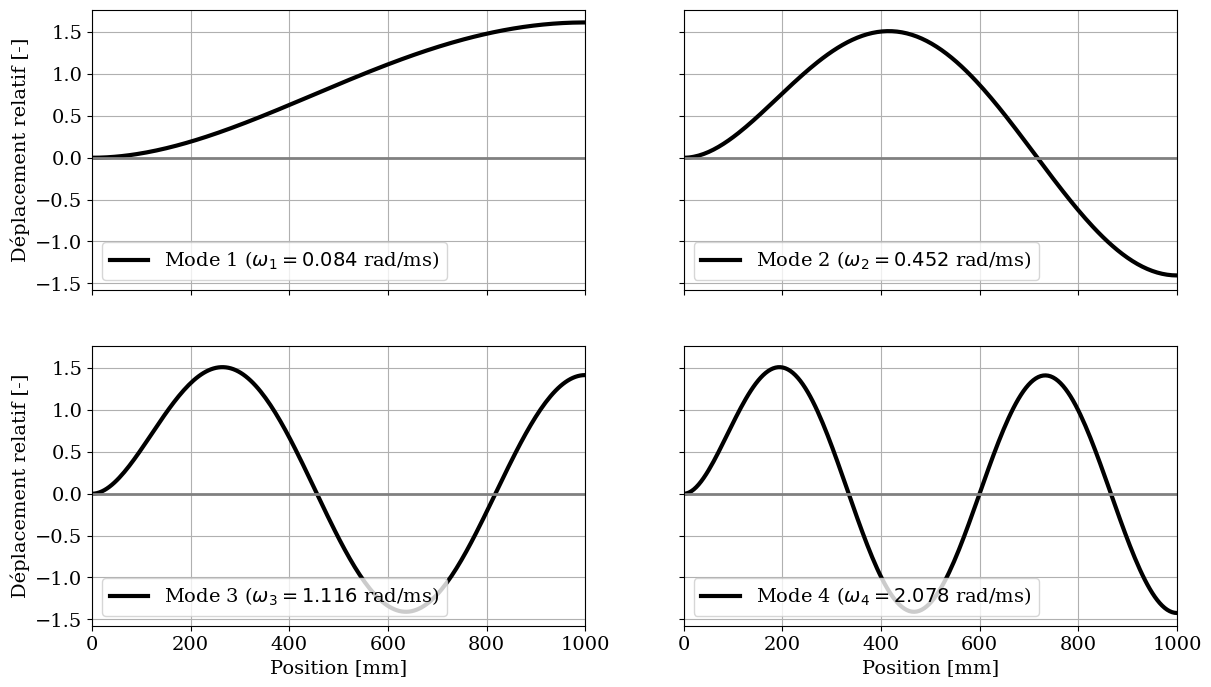

In [48]:
allx = np.linspace(0,L,200)

beta1 = 0.752809*np.pi/L
w1 = beta1**2 * np.sqrt(E*I/rho/A)
fact = (np.cos(beta1*L)-np.cosh(beta1*L))/(np.sin(beta1*L)+np.sinh(beta1*L))
mode1 = fact*(np.cos(beta1*allx) - np.cosh(beta1*allx))\
      + (np.sin(beta1*allx) - np.sinh(beta1*allx))

beta2 = 1.750001*np.pi/L
w2 = beta2**2 * np.sqrt(E*I/rho/A)
fact = (np.cos(beta2*L)-np.cosh(beta2*L))/(np.sin(beta2*L)+np.sinh(beta2*L))
mode2 = fact*(np.cos(beta2*allx) - np.cosh(beta2*allx))\
      + (np.sin(beta2*allx) - np.sinh(beta2*allx))

beta3 = 2.750675*np.pi/L 
w3 = beta3**2 * np.sqrt(E*I/rho/A)
fact = (np.cos(beta3*L)-np.cosh(beta3*L))/(np.sin(beta3*L)+np.sinh(beta3*L))
mode3 = fact*(np.cos(beta3*allx) - np.cosh(beta3*allx))\
      + (np.sin(beta3*allx) - np.sinh(beta3*allx))

beta4 = 3.752359*np.pi/L
w4 = beta4**2 * np.sqrt(E*I/rho/A)
fact = (np.cos(beta4*L)-np.cosh(beta4*L))/(np.sin(beta4*L)+np.sinh(beta4*L))
mode4 = fact*(np.cos(beta4*allx) - np.cosh(beta4*allx))\
      + (np.sin(beta4*allx) - np.sinh(beta4*allx))


# Plot
fig,axs = plt.subplots(2,2,figsize=(14,8), sharex=True, sharey=True)
axs[0,0].plot(allx, mode1, 
    label="Mode 1 ($\\omega_1 = {0:0.3f}$ rad/ms)".format(w1), linewidth=3, color="black")
axs[0,1].plot(allx, mode2, 
    label="Mode 2 ($\\omega_2 = {0:0.3f}$ rad/ms)".format(w2), linewidth=3, color="black")
axs[1,0].plot(allx, mode3, 
    label="Mode 3 ($\\omega_3 = {0:0.3f}$ rad/ms)".format(w3), linewidth=3, color="black")
axs[1,1].plot(allx, mode4, 
    label="Mode 4 ($\\omega_4 = {0:0.3f}$ rad/ms)".format(w4), linewidth=3, color="black")

for II in range(4):
    i,j = np.divmod(II,2)
    axs[i,j].plot(np.array([0,L]),np.zeros(2), color="gray", linewidth=2) 
    axs[i,j].grid(True)
    axs[i,j].legend(loc="lower left")
axs[1,0].set_xlabel("Position [mm]")
axs[1,1].set_xlabel("Position [mm]")
axs[0,0].set_ylabel("Déplacement relatif [-]")
axs[1,0].set_ylabel("Déplacement relatif [-]")
axs[0,0].set_xlim(0,L)
plt.show()

**Remarque importante :** Ces modes de vibrations ne sont directement pas les réponses à des sollicitations extérieures. Cependant, il raconte beaucoup de choses sur le comportement dynamique de la structure :

* En *oscillation libre* (pas de sollicitation extérieure), si l'on se donne comme conditions initiales :
    $$
    u_y(t=0, x) = \alpha{}U_1(x), \forall{x}, \quad\mathrm{et}\quad \dot{u}_y(t=0, x) = 0, \forall{x},
    $$
    c'est-à-dire qu'à l'instant initial $t=0$ la poutre prend la forme donnée par le premier mode de vibration, puis qu'on "lâche" la structure, alors elle va avoir des mouvements harmonieux : réponse harmonique de pulsation $\omega_1$ et de magnitude $U_1(x)$. Il en va de-même pour les autres modes de vibrations. Finalement, c'est la même que pour les systèmes discrets à n DDL.
* En *oscillation forcée*, si l'on commence à exciter la structure avec une pulsation d'excitation proche d'une pulsation propre, alors la structure va très fortement réagir : il y a résonance de la structure. La poutre va potentiellement beaucoup se déformer et la forme des oscillations va être semblable à celle donnée par la forme propre du mode excité. 
  C'est ce qu'on peut s'attendre à avoir dans notre cas d'oscillation forcée lorsque $\omega_{\mathrm{ext}} = 0.1\,\mathrm{rad\,ms^{-1}}$ (valeur donnée dans l'énoncé). La pulsation d'excitation se rapproche de la première pulsation propre $\omega_{\mathrm{ext}} \approx \omega_1$, donc on peut s'attendre à avoir une amplitude dynamique proche de la forme propre du premier mode $U_1(x)$ et potentiellement des déplacements maximaux non négligeables.

## Oscillation forcée

Le problème d'oscillation forcé est décrit par l'équation différentielle suivante :
$$
\boxed{
\rho{}A\ddot{u}_y(t,x) + E^*I u_y^{\prime\prime\prime\prime}(t,x) = 0, \quad\forall{t}, \forall{x},
}
$$
à laquelle s'ajoute les conditions initiales :

* Déplacement vertical bloqué en $x = 0$ : $$\boxed{u_y(t, x=0) = 0,~~\forall{t}.}$$
* Rotation bloquée en $x = 0$ : $$\boxed{u_y^{\prime}(t, x=0) = 0,~~\forall{t}.}$$
* Rotation bloquée en $x = L$ : $$\boxed{u_y^{\prime}(t, x=L) = 0,~~\forall{t}.}$$
* Effort tranchant connu en $x = L$ : $$\boxed{u_y^{\prime\prime\prime}(t, x=L) = -F(t)/E^*I,~~\forall{t}.}$$

Remarque : à première vue, cela ressemble très fortement à ce que nous avions lorsque nous nous sommes intéressés aux modes de vibrations. Mais il y a des différences importantes :

* Un terme de dissipation d'énergie est apparu. Le module d'Young $E$ est mainenant le module complexe $E^* = E(1 + \mathrm{i}\eta)$, où $\eta$ est appelé *facteur de perte*. 
* Il en découle que nous travaillons ici dans $\mathbb{C}$ dans un premier temps. Une fois le déplacement complexe obtenu, il s'agit de prendre sa partie réelle pour obtenir le déplacement "physique" de la structure (celui qui est observable, mesurable en pratique).
* La dernière condition aux limites fait apparaître l'effort imposé, nous sommes bien dans un cas d'oscillation forcée. Cet effort est supposé harmonique, c'est-à-dire de la forme :
  $$
  \boxed{
    F(t) = F_{\mathrm{ext}} \mathbf{e}^{\mathrm{i}\omega_{\mathrm{ext}}t},}
  $$
  où $\omega_{\mathrm{ext}}$ et $F_{\mathrm{ext}}$ sont respectivement la pulsation d'excitation et l'amplitude de cet effort extérieur s'appliquant à notre poutre.

### Amplitude complexe

La solution générale à notre problème d'oscillation forcée est de la forme :
$$
\boxed{
    u_y(t,x) = \mathcal{U}(x) \mathbf{e}^{\mathrm{i}\omega_{\mathrm{ext}}t}.}
$$
Cela traduit qu'en oscillation forcée, après un certain temps (régime établi) notre structure va osciller à la même pulsation que l'excitation (cela reste une hypothèse mais qui se vérifie bien en pratique sur des structures métalliques dans un contexte de petites perturbations). Il nous reste à déterminer l'amplitude de ces oscillations, et potentiellement le déphasage par rapport à l'effort harmonique imposé.

Par substitution (même raisonnement que pour les modes de vibration pour le coup), nous obtenons rapidement que l'amplitude complexe $\mathcal{U}(x)$ est solution de l'équation différentielle :
$$
-\omega_{\mathrm{ext}}^2\rho{}A\mathcal{U}(x) + E^*I \mathcal{U}^{\prime\prime\prime\prime}(x) = 0, \quad\forall{x}.
$$
C'est une équation de la forme :
$$
\boxed{
\mathcal{U}^{\prime\prime\prime\prime}(x) - {\beta^*}^4 \mathcal{U}(x) = 0, ~~\forall{x},
\quad\mathrm{avec~ici}\quad
\beta^* = \left(\omega_{\mathrm{ext}}^2 \frac{\rho{}A}{E^*I} \right)^{1/4} \in\mathbb{C}.}
$$

Une solution générale de cette équation est :
$$
\mathcal{U}(x)
=
\mathcal{A} \mathbf{e}^{-\mathrm{i}\beta^* x}
+
\mathcal{B} \mathbf{e}^{\mathrm{i}\beta^* x}
+
\mathcal{C} \mathbf{e}^{-\beta^* x}
+
\mathcal{D} \mathbf{e}^{\beta^* x},
$$
dont nous pouvons exprimer les dérivées :
$$
\begin{split}
\mathcal{U}^{\prime}(x)
&=
(-\mathrm{i}\beta^*)\mathcal{A} \mathbf{e}^{-\mathrm{i}\beta^* x}
+
(\mathrm{i}\beta^*)\mathcal{B} \mathbf{e}^{\mathrm{i}\beta^* x}
+
(-\beta^*)\mathcal{C} \mathbf{e}^{-\beta^* x}
+
(\beta^*)\mathcal{D} \mathbf{e}^{\beta^* x},
\\
&=
-\mathrm{i}\beta^*\mathcal{A} \mathbf{e}^{-\mathrm{i}\beta^* x}
+
\mathrm{i}\beta^*\mathcal{B} \mathbf{e}^{\mathrm{i}\beta^* x}
-
\beta^*\mathcal{C} \mathbf{e}^{-\beta^* x}
+
\beta^*\mathcal{D} \mathbf{e}^{\beta^* x},
\\[10pt]
\mathcal{U}^{\prime\prime}(x)
&=
(-\mathrm{i}\beta^*)^2\mathcal{A} \mathbf{e}^{-\mathrm{i}\beta^* x}
+
(\mathrm{i}\beta^*)^2\mathcal{B} \mathbf{e}^{\mathrm{i}\beta^* x}
+
(-\beta^*)^2\mathcal{C} \mathbf{e}^{-\beta^* x}
+
(\beta^*)^2\mathcal{D} \mathbf{e}^{\beta^* x},
\\
&=
-
{\beta^*}^2\mathcal{A} \mathbf{e}^{-\mathrm{i}\beta^* x}
-
{\beta^*}^2\mathcal{B} \mathbf{e}^{\mathrm{i}\beta^* x}
+
{\beta^*}^2\mathcal{C} \mathbf{e}^{-\beta^* x}
+
{\beta^*}^2\mathcal{D} \mathbf{e}^{\beta^* x},
\\[10pt]
\mathcal{U}^{\prime\prime\prime}(x)
&=
(-\mathrm{i}\beta^*)^3\mathcal{A} \mathbf{e}^{-\mathrm{i}\beta^* x}
+
(\mathrm{i}\beta^*)^3\mathcal{B} \mathbf{e}^{\mathrm{i}\beta^* x}
+
(-\beta^*)^3\mathcal{C} \mathbf{e}^{-\beta^* x}
+
(\beta^*)^3\mathcal{D} \mathbf{e}^{\beta^* x},\\
&=
\mathrm{i}{\beta^*}^3\mathcal{A} \mathbf{e}^{-\mathrm{i}\beta^* x}
-
\mathrm{i}{\beta^*}^3\mathcal{B} \mathbf{e}^{\mathrm{i}\beta^* x}
-
{\beta^*}^3\mathcal{C} \mathbf{e}^{-\beta^* x}
+
{\beta^*}^3\mathcal{D} \mathbf{e}^{\beta^* x}.
\end{split}
$$

Nous sommes à un stade où il nous reste à identifier les valeurs de $\mathcal{A}, \mathcal{B}, \mathcal{C}, \mathcal{D}$. Ces constantes sont déterminées à partir des conditions aux limites, précédemment définies. Nous avons :

* Déplacement vertical bloqué en $x = 0$ : 
  $$
  \begin{split}
    u_y(t, x=0) = 0,~~\forall{t},
    \quad\Rightarrow\quad&
    \mathcal{U}(x=0) = 0, \\
    \quad\Rightarrow\quad&
    \mathcal{A} \underbrace{\mathbf{e}^{-\mathrm{i}\beta^* 0}}_{=1} 
    +
    \mathcal{B} \underbrace{\mathbf{e}^{\mathrm{i}\beta^* 0}}_{=1} 
    +
    \mathcal{C} \underbrace{\mathbf{e}^{-\beta^* 0}}_{=1} 
    +
    \mathcal{D} \underbrace{\mathbf{e}^{\beta^* 0}}_{=1} 
    +
    0,\\
    \quad\Rightarrow\quad&
    \boxed{\mathcal{A} + \mathcal{B} + \mathcal{C} + \mathcal{D} = 0.}
  \end{split}
  $$
* Rotation bloquée en $x = 0$ : 
  $$
  \begin{split}
    u_y^\prime(t, x=0) = 0,~~\forall{t},
    \quad\Rightarrow\quad&
    \mathcal{U}^\prime(x=0) = 0, \\
    \quad\Rightarrow\quad&
    -\mathrm{i}\beta^*\mathcal{A} \mathbf{e}^{-\mathrm{i}\beta^* 0}
    +
    \mathrm{i}\beta^*\mathcal{B} \mathbf{e}^{\mathrm{i}\beta^* 0}
    -
    \beta^*\mathcal{C} \mathbf{e}^{-\beta^* 0}
    +
    \beta^*\mathcal{D} \mathbf{e}^{\beta^* 0}
    =
    0,\\
    \quad\Rightarrow\quad&
    -\mathrm{i}\beta^*\mathcal{A}
    +\mathrm{i}\beta^*\mathcal{B}
    -\beta^*\mathcal{C}
    +\beta^*\mathcal{D}
    =
    0,
    \\
    \quad\Rightarrow\quad&
    \boxed{-\mathrm{i}\mathcal{A} + \mathrm{i}\mathcal{B} - \mathcal{C} + \mathcal{D} = 0.}
  \end{split}
  $$
* Rotation bloquée en $x = L$ : 
  $$
  \begin{split}
    u_y^\prime(t, x=L) = 0,~~\forall{t},
    \quad\Rightarrow\quad&
    \mathcal{U}^\prime(x=LM) = 0, \\
    \quad\Rightarrow\quad&
    -\mathrm{i}\beta^*\mathcal{A} \mathbf{e}^{-\mathrm{i}\beta^* L}
    +
    \mathrm{i}\beta^*\mathcal{B} \mathbf{e}^{\mathrm{i}\beta^* L}
    -
    \beta^*\mathcal{C} \mathbf{e}^{-\beta^* L}
    +
    \beta^*\mathcal{D} \mathbf{e}^{\beta^* L}
    =
    0,
    \\
    \quad\Rightarrow\quad&
    \boxed{-\mathrm{i}\mathbf{e}^{-\mathrm{i}\beta^* L}\mathcal{A} + \mathrm{i}\mathbf{e}^{\mathrm{i}\beta^* L}\mathcal{B} - \mathbf{e}^{-\beta^* L}\mathcal{C} + \mathbf{e}^{\beta^* L}\mathcal{D} = 0.}
  \end{split}
  $$
* Force harmonique imposée en $x=L$ :
  $$
  \begin{split}
    &u_y^{\prime\prime\prime}(t, x=L) = -\frac{F_{\mathrm{ext}}}{E^*I} \mathbf{e}^{\mathrm{i}\omega_{\mathrm{ext}}t},~~\forall{t},\\[10pt]
    &\Rightarrow\quad
    \mathcal{U}^{\prime\prime\prime}(x=LM) = -{F_{\mathrm{ext}}}/{E^*I}, \\
    &\Rightarrow\quad
    \mathrm{i}{\beta^*}^3\mathcal{A} \mathbf{e}^{-\mathrm{i}\beta^* L}
    -
    \mathrm{i}{\beta^*}^3\mathcal{B} \mathbf{e}^{\mathrm{i}\beta^* L}
    -
    {\beta^*}^3\mathcal{C} \mathbf{e}^{-\beta^* L}
    +
    {\beta^*}^3\mathcal{D} \mathbf{e}^{\beta^* L}
    =
    -{F_{\mathrm{ext}}}/{E^*I},
    \\
    &\Rightarrow\quad
    \boxed{
      \mathrm{i}{\beta^*}^3 \mathbf{e}^{-\mathrm{i}\beta^* L}\mathcal{A}
      -
      \mathrm{i}{\beta^*}^3 \mathbf{e}^{\mathrm{i}\beta^* L}\mathcal{B}
      -
      {\beta^*}^3 \mathbf{e}^{-\beta^* L}\mathcal{C}
      +
      {\beta^*}^3 \mathbf{e}^{\beta^* L}\mathcal{D}
      =
      -{F_{\mathrm{ext}}}/{E^*I}.
    }
  \end{split}
  $$

Ces quatres équations peuvent être utilisées pour former un système linéaire où les quatres constantes $\mathcal{A}, \mathcal{B}, \mathcal{C}, \mathcal{D}$ en sont les inconnues :
$$
\begin{bmatrix}
  1 & 1 & 1 & 1 \\
  -\mathrm{i} & \mathrm{i} & -1 &  1 \\
  -\mathrm{i}\mathbf{e}^{-\mathrm{i}\beta^* L} & \mathrm{i}\mathbf{e}^{\mathrm{i}\beta^* L} & - \mathbf{e}^{-\beta^* L} & \mathbf{e}^{\beta^* L}\\
  \mathrm{i}{\beta^*}^3 \mathbf{e}^{-\mathrm{i}\beta^* L}
  & -\mathrm{i}{\beta^*}^3 \mathbf{e}^{\mathrm{i}\beta^* L}
  & -{\beta^*}^3 \mathbf{e}^{-\beta^* L}
  & {\beta^*}^3 \mathbf{e}^{\beta^* L}
\end{bmatrix}
\begin{pmatrix}
\mathcal{A} \\ \mathcal{B} \\ \mathcal{C} \\ \mathcal{D}
\end{pmatrix}
=
\begin{pmatrix}
0 \\ 0 \\ 0 \\ -{F_{\mathrm{ext}}}/{E^*I}
\end{pmatrix}.
$$
La résolution de ce système nous permet d'obtenir les quatres constantes, et donc notre amplitude complexe $\mathcal{U}(x)$. Il est important de noté que cette amplitude dépend de la pulsation d'excitation : en effet, il faut se rappeler de l'expression de $\beta^*$ qui faisait effectivement intervenir $\omega_{\mathrm{ext}}$. Ainsi, il peut être intéressant de tracer le diagramme de Bode de l'amplification dynamique, en se plaçant par exemple en $x=L$ (c'est-à-dire que l'on regarde l'amplification dynamique de déplacement en bout de poutre):

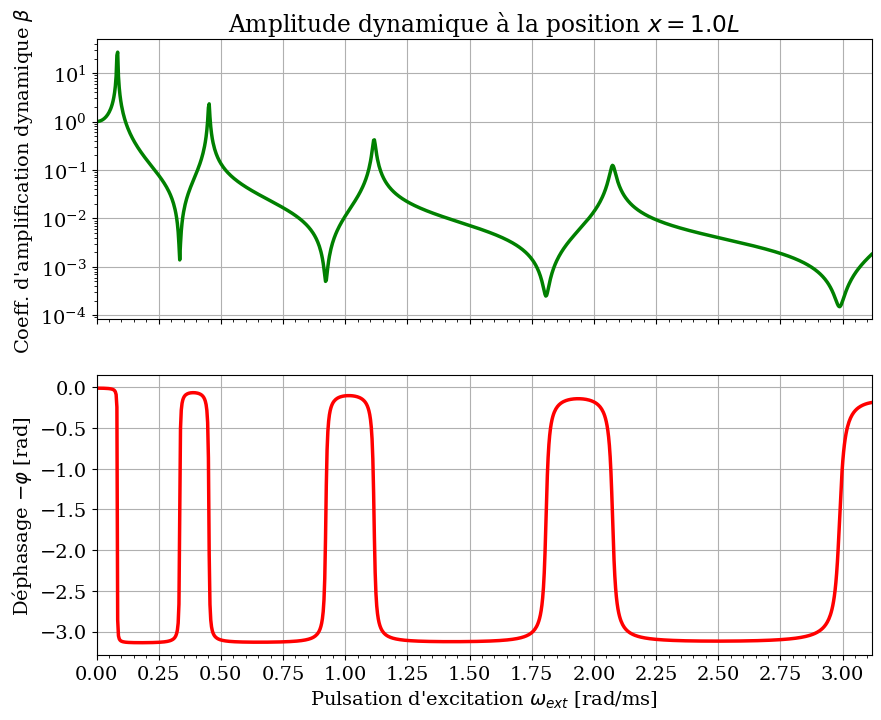

In [49]:
def determineCste(w:float):
    Bstar = np.power(w**2*rho*A/Estar/I, 0.25)
    matA = np.array(
        [[1.0, 1.0, 1.0, 1.0],
         [-1j,  1j,-1.0, 1.0],
         [-1j*np.exp(-1j*Bstar*L), 1j*np.exp(1j*Bstar*L), -np.exp(-Bstar*L), np.exp(Bstar*L)],
         [1j*Bstar**3*np.exp(-1j*Bstar*L), -1j*Bstar**3*np.exp(1j*Bstar*L), -Bstar**3*np.exp(-Bstar*L), Bstar**3*np.exp(Bstar*L)]])
    vecb = np.array([0.0, 0.0, 0.0, -Fext/Estar/I])
    return np.linalg.solve(matA, vecb).tolist()

def Ucomplex(w:float, x:float):
    uA,uB,uC,uD = determineCste(w)
    Bstar = np.power(w**2*rho*A/Estar/I, 0.25)
    U = uA*np.exp(-1j*Bstar*x) + uB*np.exp(1j*Bstar*x) + uC*np.exp(-Bstar*x) + uD*np.exp(Bstar*x)
    return U

# Plot
xplot = L
allw = np.linspace(0.01*w1,1.5*w4, 1000)

allU = np.array([Ucomplex(w, xplot) for w in allw])
allBeta = np.absolute(allU)/np.absolute(allU[0])
allPhi  = -np.angle(allU)

fig, axs = plt.subplots(2,1,sharex=True,figsize=(10,8))
axs[0].plot(allw, allBeta,
    linewidth=2.5,color="green")
axs[1].plot(allw, -allPhi,
    linewidth=2.5,color="red")
axs[0].set_title("Amplitude dynamique à la position $x = {0:1.1f}L$".format(xplot/L))
axs[0].set_ylabel("Coeff. d'amplification dynamique $\\beta$")
axs[0].set_yscale('log', base=10)
axs[0].grid(visible=True)
axs[1].set_xlabel("Pulsation d'excitation $\\omega_{ext}$ [rad/ms]")
axs[1].set_ylabel("Déphasage $-\\varphi$ [rad]")
axs[1].grid(visible=True)
# axs[1].xaxis.set_ticks(np.arange(0.0, allw.max(), 0.2))
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(0.25))
axs[1].xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
axs[1].set_xlim(0.0, allw.max())
plt.show()


**Observations :** 

* Nous voyons directement la présence de "pics" que nous pouvons associés à des phénomènes de résonance. Il est d'autant plus intéressant que les pulsations de résonance semblent très proches des pulsations propres déterminée préalablement. 
* Lorsque la pulsation d'excitation est faible (relativement à la première pulsation de résonance), le coefficient d'amplification dynamique est de un : nous sommes dans un régime quasi-statique, il n'y a pas d'amplification par rapport à la solution statique.
* Lorsque la pulsation d'excitation est grande, coefficient d'amplification dynamique tend vers zéro. Le déplacement en bout de poutre ($x=L$) devient quasiment nul.

### Réponse temporelle

Intéressant nous finalement à la réponse temporelle de la poutre.

#### Cas (quasi)-statique

Il peut être intéressant de déterminer dans un premier temps le cas (quasi)-statique, afin d'avoir des résultats de référence et voir si le cas dynamique est plus critique que le cas statique ou inversement.

Dans une approche type "résistance des matériaux", notre problème de poutre est un cas hyperstatique. Il est possible d'utiliser le principe de superposition ou un théorème énergétique pour résoudre l'équilibre de la structure. Une approche alternative est de partir de l'équation d'équilibre local :
$$
\boxed{EI u_y^{\prime\prime\prime\prime}(x) = 0, \quad\forall{x}.
}
$$
Ce n'est ni plus ni moins que notre équation du mouvement précédent où le terme inertiel a été négligé. Il n'y a plus de dépendance au temps (ni de terme dissipatif). 
A cette équation d'équilibre local statique, s'ajoute (à nouveau) les conditions aux limites suivantes :

* Déplacement vertical et rotation bloqués en $x = 0$ : 
  $$
    u_y(x=0) = 0,
    \quad
    u_y^\prime(x=0) = 0.
  $$
* Rotation bloquée et effort imposé en $x = L$ :
  $$
    u_y^{\prime}(x=L) = 0,
    \quad
    u_y^{\prime\prime\prime}(x=L) = -F_{\mathrm{ext}}/EI.
  $$

Résolution :
$$
\begin{aligned}
&\mathrm{Intégration}:      & EI u_y^{\prime\prime\prime}(x) &= C_1, \\
&\mathrm{CL~effort~imposé}: & EI u_y^{\prime\prime\prime}(L) &= -F_{\mathrm{ext}} & \Rightarrow&& C_1 &= -F_{\mathrm{ext}},\\[5pt]
&\mathrm{Intégration}:      & EI u_y^{\prime\prime}(x) &= -F_{\mathrm{ext}}x + C_2, \\
&\mathrm{Intégration}:      & EI u_y^{\prime}(x) &= -\frac{1}{2}F_{\mathrm{ext}}x^2 + C_2 x + C_3, \\
&\mathrm{CL~rot.~nulle~en~0}: & EI u_y^{\prime}(0) &= -\frac{1}{2}F_{\mathrm{ext}}0^2 + C_2 0 + C_3& \Rightarrow&& C_3 &= 0,\\
&\mathrm{CL~rot.~nulle~en~L}: & EI u_y^{\prime}(L) &= -\frac{1}{2}F_{\mathrm{ext}}L^2 + C_2 L & \Rightarrow&& C_2 &= \frac{1}{2}F_{\mathrm{ext}}L,\\[5pt]
&\mathrm{Intégration}:      & EI u_y(x) &= -\frac{1}{6}F_{\mathrm{ext}}x^3 + \frac{1}{4}F_{\mathrm{ext}}L x^2 + C_4, \\
&\mathrm{CL~dépl.~nul~en~0}: & EI u_y(0) &= -\frac{1}{6}F_{\mathrm{ext}}0^3 + \frac{1}{4}F_{\mathrm{ext}}L 0^2 + C_4& \Rightarrow&& C_4 &= 0.
\end{aligned}
$$
Nous en déduisons les expressions du déplacement, du moment fléchissant, et de l'effort tranchant pour le cas statique comme :
$$
\boxed{
    \phantom{\bigg(}
    u_y^{\mathrm{static}}(x) = \frac{F_{\mathrm{ext}} x^2}{12 EI}\left( 3L - 2x \right)
    \phantom{\bigg)}
}
\quad
\boxed{
    \phantom{\bigg(}
    M_z^{\mathrm{static}}(x) = \frac{F_{\mathrm{ext}}}{2 }\left( L - 2x \right)
    \phantom{\bigg)}
}
\quad
\boxed{
    \phantom{\bigg(}
    V_y^{\mathrm{static}}(x) = F_{\mathrm{ext}}
    \phantom{\bigg)}
}
$$

#### Cas dynamique

Une fois l'amplitude complexe $\mathcal{U}(x)$ déterminé, il s'agit de remonter à la réponse temporelle et d'en prendre la partie réelle. En d'autres termes, le déplacement est donné par :
$$
\boxed{
    \phantom{\bigg(}
    u_y(t,x) = \mathfrak{R}( \mathcal{U}(x) \mathbf{e}^{\mathrm{i}\omega_{\mathrm{ext}}t}  )
    \phantom{\bigg)}
}
$$
et le moment fléchissant, et l'effort tranchant sont donnés par :
$$
\boxed{
    \phantom{\bigg(}
    M_z(t,x) = \mathfrak{R}(E^*I\,\mathcal{U}^{\prime\prime}(x) \mathbf{e}^{\mathrm{i}\omega_{\mathrm{ext}}t}  )
    \phantom{\bigg)}
}
\quad
\boxed{
    \phantom{\bigg(}
    V_y(t,x) = \mathfrak{R}(-E^*I\,\mathcal{U}^{\prime\prime\prime}(x) \mathbf{e}^{\mathrm{i}\omega_{\mathrm{ext}}t}  )
    \phantom{\bigg)}
}
$$

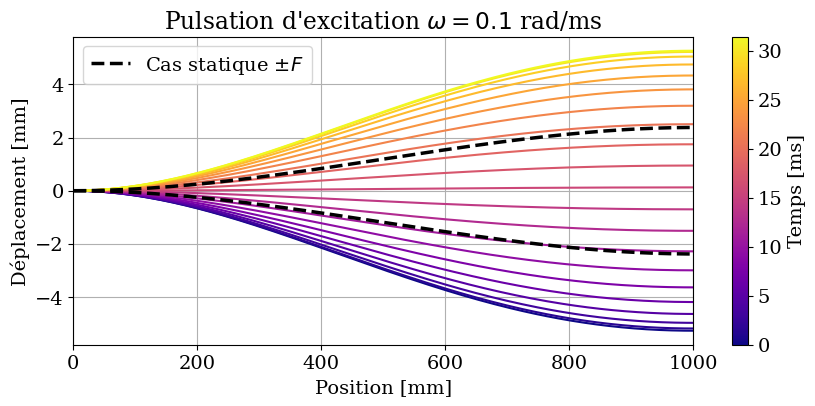

In [50]:
def disp(t:float,x:float):
    U = Ucomplex(wext, x)
    return np.real(U*np.exp(1j*wext*t))
def dispStatic(x:float):
    return Fext*x**2/12/E/I*(3*L-2*x)

# Plot
nt = 21
allt = np.linspace(0,np.pi/wext,nt)
cmap = colormaps['plasma']
colors = cmap(np.linspace(0, 1, nt))

fig,ax = plt.subplots(figsize = (10,4))
for i, color in enumerate(colors):
    tplot = allt[i]
    ax.plot(allx, disp(tplot,allx), color=color)
ax.plot(allx, dispStatic(allx), linewidth=2.5, color="black", linestyle="dashed", label="Cas statique $\pm F$")
ax.plot(allx,-dispStatic(allx), linewidth=2.5, color="black", linestyle="dashed")
ax.grid(True)
ax.legend(loc="upper left")
ax.set_xlim(0,L)
ax.set_xlabel("Position [mm]")
ax.set_ylabel("Déplacement [mm]")
ax.set_title("Pulsation d'excitation $\\omega = {0}$ rad/ms".format(wext))
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, allt[-1]), cmap=cmap),
             ax=ax, label="Temps [ms]")

plt.show()

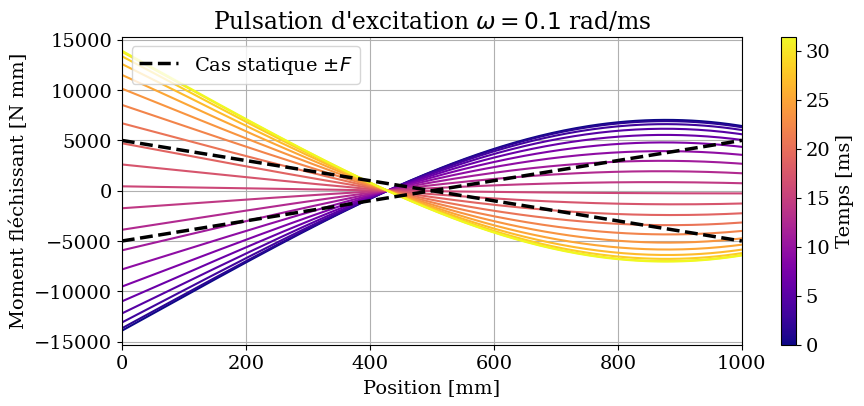

In [51]:
def moment(t:float,x:float):
    uA,uB,uC,uD = determineCste(wext)
    Bstar = np.power(wext**2*rho*A/Estar/I, 0.25)
    Upprime = (-1j*Bstar)**2*uA*np.exp(-1j*Bstar*x) + (1j*Bstar)**2*uB*np.exp(1j*Bstar*x) + (-Bstar)**2*uC*np.exp(-Bstar*x) + (Bstar)**2*uD*np.exp(Bstar*x)
    M = Estar*I*Upprime
    return np.real(M*np.exp(1j*wext*t))
def momentStatic(x:float):
    return Fext/2*(L-2*x)

# Plot
nt = 21
allt = np.linspace(0,np.pi/wext,nt)
cmap = colormaps['plasma']
colors = cmap(np.linspace(0, 1, nt))

fig,ax = plt.subplots(figsize = (10,4))
for i, color in enumerate(colors):
    tplot = allt[i]
    ax.plot(allx, moment(tplot,allx), color=color)
ax.plot(allx, momentStatic(allx), linewidth=2.5, color="black", linestyle="dashed", label="Cas statique $\pm F$")
ax.plot(allx,-momentStatic(allx), linewidth=2.5, color="black", linestyle="dashed")
ax.grid(True)
ax.legend(loc="upper left")
ax.set_xlim(0,L)
ax.set_xlabel("Position [mm]")
ax.set_ylabel("Moment fléchissant [N mm]")
ax.set_title("Pulsation d'excitation $\\omega = {0}$ rad/ms".format(wext))
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, allt[-1]), cmap=cmap),
             ax=ax, label="Temps [ms]")

plt.show()

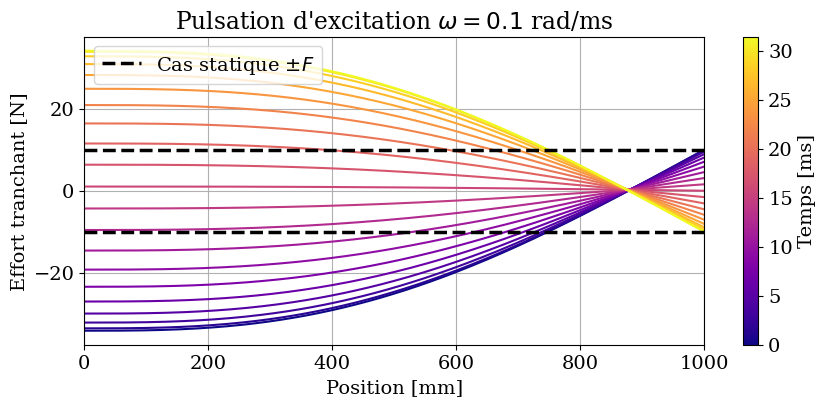

In [52]:
def effortV(t:float,x:float):
    uA,uB,uC,uD = determineCste(wext)
    Bstar = np.power(wext**2*rho*A/Estar/I, 0.25)
    Uppprime = (-1j*Bstar)**3*uA*np.exp(-1j*Bstar*x) + (1j*Bstar)**3*uB*np.exp(1j*Bstar*x) + (-Bstar)**3*uC*np.exp(-Bstar*x) + (Bstar)**3*uD*np.exp(Bstar*x)
    V = -Estar*I*Uppprime
    return np.real(V*np.exp(1j*wext*t))
def effortVstatic(x:float):
    return Fext*np.ones_like(x)

# Plot
nt = 21
allt = np.linspace(0,np.pi/wext,nt)
cmap = colormaps['plasma']
colors = cmap(np.linspace(0, 1, nt))

fig,ax = plt.subplots(figsize = (10,4))
for i, color in enumerate(colors):
    tplot = allt[i]
    ax.plot(allx, effortV(tplot,allx), color=color)
ax.plot(allx, effortVstatic(allx), linewidth=2.5, color="black", linestyle="dashed", label="Cas statique $\pm F$")
ax.plot(allx,-effortVstatic(allx), linewidth=2.5, color="black", linestyle="dashed")
ax.grid(True)
ax.legend(loc="upper left")
ax.set_xlim(0,L)
ax.set_xlabel("Position [mm]")
ax.set_ylabel("Effort tranchant [N]")
ax.set_title("Pulsation d'excitation $\\omega = {0}$ rad/ms".format(wext))
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, allt[-1]), cmap=cmap),
             ax=ax, label="Temps [ms]")

plt.show()